#### Pytorch, NN

Inside Deep Learning, Raff, 2022

In [68]:
import torch
import numpy as np
import seaborn as sns
import timeit
import matplotlib.pyplot as plt

In [69]:
torch_scalar = torch.tensor(3.14)
torch_vector = torch.tensor([1, 2, 3, 4])
torch_matrix = torch.tensor([
    [1, 2],
    [3, 4],
    [5, 6],
    [7, 8],
])
torch_tensor3d = torch.tensor([
    [
        [1, 2, 3],
        [4, 5, 6],
    ],
    [
        [7, 8, 9],
        [10, 11, 12]
    ],
])

In [70]:
print(torch_scalar.shape)
print(torch_vector.shape)
print(torch_matrix.shape)
print(torch_tensor3d.shape)

torch.Size([])
torch.Size([4])
torch.Size([4, 2])
torch.Size([2, 2, 3])


In [71]:
x_np = np.random.random([4, 4]).astype(np.float32)
print(x_np)

[[0.43519935 0.41034225 0.8479865  0.48031467]
 [0.8486224  0.0481709  0.9214057  0.30254498]
 [0.2105827  0.19351986 0.98613286 0.86944485]
 [0.03485484 0.14607485 0.1007104  0.8579945 ]]


In [72]:
x_pt = torch.tensor(x_np, dtype=torch.float32)
print(x_pt)

tensor([[0.4352, 0.4103, 0.8480, 0.4803],
        [0.8486, 0.0482, 0.9214, 0.3025],
        [0.2106, 0.1935, 0.9861, 0.8694],
        [0.0349, 0.1461, 0.1007, 0.8580]])


In [73]:
b_pt = x_pt > 0.5
print(b_pt)
print(b_pt.dtype)

tensor([[False, False,  True, False],
        [ True, False,  True, False],
        [False, False,  True,  True],
        [False, False, False,  True]])
torch.bool


In [74]:
torch.sum(x_pt)

tensor(7.6939)

In [75]:
np.transpose(x_np)

array([[0.43519935, 0.8486224 , 0.2105827 , 0.03485484],
       [0.41034225, 0.0481709 , 0.19351986, 0.14607485],
       [0.8479865 , 0.9214057 , 0.98613286, 0.1007104 ],
       [0.48031467, 0.30254498, 0.86944485, 0.8579945 ]], dtype=float32)

In [76]:
torch.transpose(x_pt, 0, 1)

tensor([[0.4352, 0.8486, 0.2106, 0.0349],
        [0.4103, 0.0482, 0.1935, 0.1461],
        [0.8480, 0.9214, 0.9861, 0.1007],
        [0.4803, 0.3025, 0.8694, 0.8580]])

### MAC M1 GPU on Pytorch

In [77]:

x = torch.rand(2**11, 2**11)
time_cpu = timeit.timeit("x@x", globals=globals(), number=100)
print(f"GPU time: {time_cpu:.2f} s")

GPU time: 1.18 s


In [78]:
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

True
True


In [79]:
device = torch.device("mps") # PyTorch uses Apple’s Metal Performance Shaders (MPS)
x = x.to(device)
time_gpu = timeit.timeit("x@x", globals=globals(), number=100)
print(f"GPU time: {time_gpu:.2f} s")

GPU time: 0.01 s


El autor menciona que cuando tenemos una lista o un diccionario que contiene tensores, debemos pasar esos *tensores* a la GPU:

In [80]:
def moveTo(obj, device):
    """
    obj: the python object ot move to a device, or to move its contents to a device
    device: the compute device to move objects to
    """
    if isinstance(obj, list):
        return [moveTo(o, device) for o in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(o, device) for o in obj)
    elif isinstance(obj, set):
        return set(moveTo(o, device) for o in obj)
    elif isinstance(obj, dict):
        to_ret = dict()
        for k, v in obj.items():
            to_ret[moveTo(k, device)] = moveTo(v, device)
        return to_ret
    elif hasattr(obj, "to"):
        return obj.to(device)
    else:
        return obj

In [81]:
some_tensors = [torch.tensor(1), torch.tensor(2)]
print(some_tensors)
print(moveTo(some_tensors, device))

[tensor(1), tensor(2)]
[tensor(1, device='mps:0'), tensor(2, device='mps:0')]


#### Automatic differentiation

Esta es una de las ventajas de Pytorch, calcula las derivadas (gradientes) automaticamente.

<Axes: >

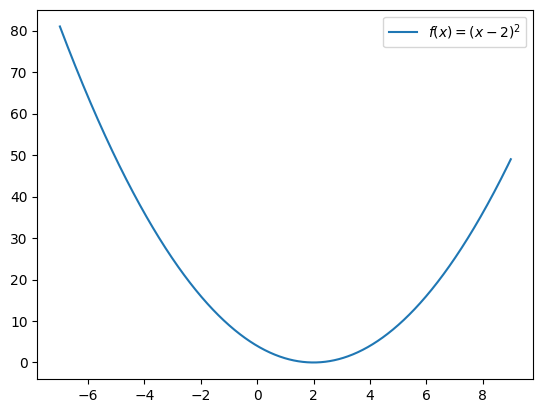

In [82]:
def f(x):
    return torch.pow((x-2.0), 2)

x_axis_vals = np.linspace(-7, 9 , 1000)
y_axis_vals = f(torch.tensor(x_axis_vals)).numpy()

sns.lineplot(x=x_axis_vals, y=y_axis_vals, label='$f(x) = (x-2)^2$')

<Axes: >

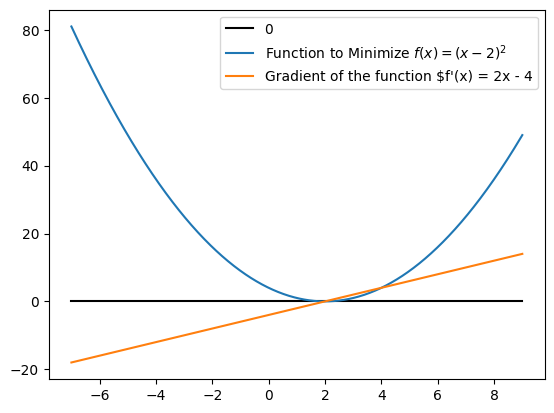

In [83]:
def fP(x):
    return 2*x - 4

y_axis_vals_p = fP(torch.tensor(x_axis_vals)).numpy()

sns.lineplot(x=x_axis_vals, y=[0.0]*len(x_axis_vals), label="0", color="black")
sns.lineplot(x=x_axis_vals, y=y_axis_vals, label='Function to Minimize $f(x) = (x - 2)^2$')
sns.lineplot(x=x_axis_vals, y=y_axis_vals_p, label="Gradient of the function $f'(x) = 2x - 4")

El signo del gradiente nos dice hacia donde se debe mover la variable para acercanos mas al minimo! Adicionalmente $|f'(x)|$ nos dice que tan lejos estamos del minimo y que tan rapido se debe mover la variable.

In [84]:
# ahora se hara un ejemplo utilizando torch para ir calculando los gradientes
x = torch.tensor([-3.5], requires_grad=True)
print(x.grad) # deberia imprimir None ya que por ahora no estoy usando esta variable en nada

None


In [85]:
# calculo una funcion y ya se ve que se menciona una funcion de gradientes
value = f(x)
print(value)

tensor([30.2500], grad_fn=<PowBackward0>)


In [86]:
# a medida que se van acumulando funciones pytorch va guardando
# la funcion gradiente y una vez ya lleguemos a un escalar
# se puede usar backpropagation para calcular los gradientes
# de cada nodo
value.backward()
print(x.grad)

tensor([-11.])


In [87]:
# ahora se hara un ejemplo completo de como se puede usar el gradiente
# sugiere revisar el 2-norm entre el actual valor de x y el valor pasado
# y cuando este valor sea muy bajo, se detiene el proceso.

# este proceso es un poco raro para mi, puesto que no se fija en el valor actual
# de la funcion.

x = torch.tensor(-3.5, requires_grad=True)

x_cur = x.clone()
x_prev = x_cur*100 # para que entre al while

epsilon = 1e-5
eta = 0.1 # basicamente es el learning rate

while torch.linalg.norm(x_cur - x_prev) > epsilon:
    x_prev = x_cur.clone()
    value = f(x)
    value.backward()
    x.data = x.data - eta*x.grad

    x.grad.zero_() # esto es para que no se acumulen los gradientes

    x_cur = x.data # esto es para que se guarde el valor actual de x sin los gradientes

print(x_cur)

tensor(2.0000)


In [88]:
# es bien interesante que los tensores se pueden convertir a
# un objeto especial nn.Parameter, esto nos habilita para crear
# un optimizer que se encargue de actualizar los parametros
# buscando el minimo de una funcion
x_param = torch.nn.Parameter(torch.tensor([-3.5], requires_grad=True))
optimizer = torch.optim.SGD([x_param], lr=eta)

for epoch in range(100):
    optimizer.zero_grad()
    loss_incurred = f(x_param)
    loss_incurred.backward()
    optimizer.step()
print(x_param.data)

tensor([2.0000])


In [89]:
from torch.utils.data import Dataset
from sklearn.datasets import fetch_openml

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
print(X.shape)

/Users/fabio/.local/share/virtualenvs/hundred_concepts-iMWKXiWN/lib/python3.9/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000, 784)


In [112]:
class SimpleDataset(Dataset):
    def __init__(self, X, y):
        super(SimpleDataset, self).__init__()
        self.X = X
        self.y = y
    
    def __getitem__(self, index):
        inputs = torch.tensor(self.X.values[index, :], dtype=torch.float32)
        targets = torch.tensor(int(self.y.values[index]), dtype=torch.int64)
        return inputs, targets
    
    def __len__(self):
        return self.X.shape[0]

dataset = SimpleDataset(X, y)

Length of dataset: 70000
Features:  torch.Size([784])
Label of index 0: tensor(5)


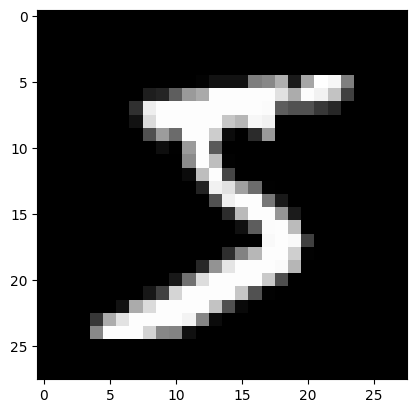

In [114]:
print('Length of dataset:', len(dataset))
example, label = dataset[0]
print('Features: ', example.shape)
print('Label of index 0:', label)

plt.imshow(example.reshape(28, 28), cmap='gray')
plt.show()

In [115]:
# ahora se hara un ejemplo de como dividir entre train y test
train_size = int(len(dataset)*0.8)
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size]
)

print('Length of train dataset:', len(train_dataset))
print('Length of test dataset:', len(test_dataset))

Length of train dataset: 56000
Length of test dataset: 14000
